In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath('/home/zzaher/mode_muon_tomography'))

In [3]:
from typing import *
import numpy as np
from functools import partial
from fastprogress import progress_bar
import pandas as pd
import h5py

from lumin.plotting.results import plot_roc

import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch._vmap_internals import _vmap as vmap

from tomopt.volume import *
from tomopt.muon import *
from tomopt.inference import *
from tomopt.optimisation import *
from tomopt.core import *
from tomopt.utils import *
from tomopt.plotting import *

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
DEVICE = torch.device("cpu")

In [5]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 1.0
    init_res = 1e4
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5], device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0] if i in [0,3] else [0.5,0.5], device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

In [8]:
volume


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000]) with budget scale tensor([1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000]) with budget scale tensor([1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.]) with budget scale tensor([1.])
      )
    )
    (1): PassiveLayer located at z=tensor([0.8000])
    (2): PassiveLayer located at z=tensor([0.7000])
    (3): PassiveLayer located at z=tensor([0.6000])
    (4): PassiveLayer

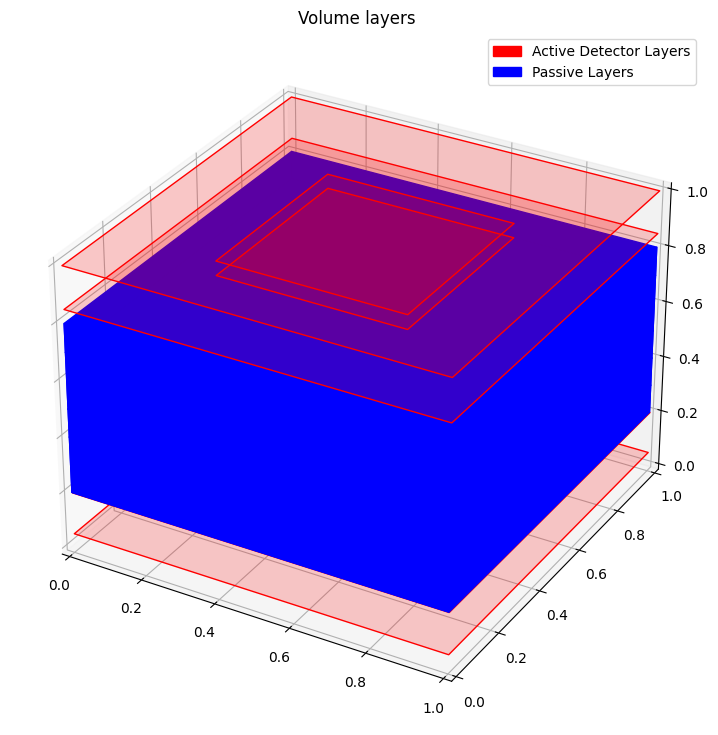

In [9]:
volume.draw(xlim=([0,1]), ylim=([0,1]), zlim=([0,1]))

In [10]:
def sig_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z > 0.4 and z <= 0.5: rad_length[7:,6:] = X0['uranium']
    return rad_length

In [11]:
def bkg_rad_length(*,z:float, lw:Tensor, size:float) -> Tensor:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    return rad_length

# Build dataset

In [12]:
def get_preds(volume:Volume) -> Tensor:
    gen = MuonGenerator2016.from_volume(volume)
    mus = MuonResampler.resample(gen(250), volume=volume, gen=gen)
    mu = MuonBatch(mus, init_z=volume.h)
    volume(mu)
    
    sb = ScatterBatch(mu, volume)
    inf = PanelX0Inferrer(volume)
    inf.add_scatters(sb)
    vox_preds, weights = inf.get_prediction()
    return vox_preds

In [13]:
sigs, bkgs = [], []
for i in progress_bar(range(100)):
    volume.load_rad_length(sig_rad_length)
    sigs.append(get_preds(volume).detach())
    volume.load_rad_length(bkg_rad_length)
    bkgs.append(get_preds(volume).detach())

In [14]:
sig = torch.stack(sigs)
bkg = torch.stack(bkgs)

In [17]:
with h5py.File('bimodal_data_1e4.hdf5', "w") as outfile:
    outfile.create_dataset('sig', data=sig, compression='lzf')
    outfile.create_dataset('bkg', data=bkg, compression='lzf')

In [18]:
with h5py.File('bimodal_data_1e4.hdf5', "r") as infile:
    sig = Tensor(infile['sig'][()])
    bkg = Tensor(infile['bkg'][()])
data = torch.cat([sig, bkg], dim=0)

# Vars

In [19]:
stargs = torch.ones(len(sig))
btargs = torch.zeros(len(bkg))

In [20]:
sig = pd.DataFrame(stargs, columns=['gen_target'])
bkg = pd.DataFrame(btargs, columns=['gen_target'])
df = sig.append(bkg, ignore_index=True)

/tmp/ipykernel_6934/2629512755.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = sig.append(bkg, ignore_index=True)


In [21]:
df

,gen_target
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
195,0.0
196,0.0
197,0.0
198,0.0


## Simple ranking

In [22]:
def lowest_frac(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    return vox_preds.mean()-vox_preds[vox_preds<cut].mean()

In [25]:
df['lowest_frac'] = torch.stack([lowest_frac(d) for d in data.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


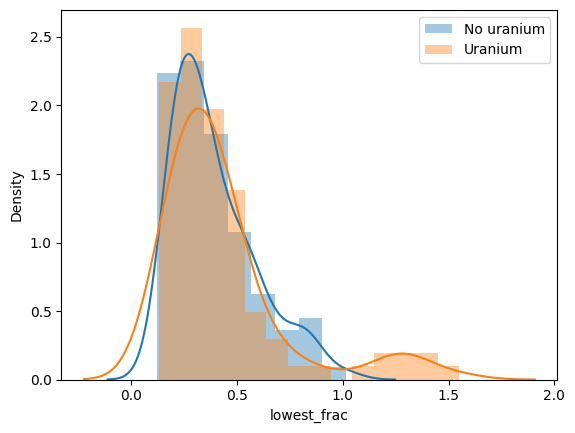

In [26]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac'], label='Uranium')
plt.legend()

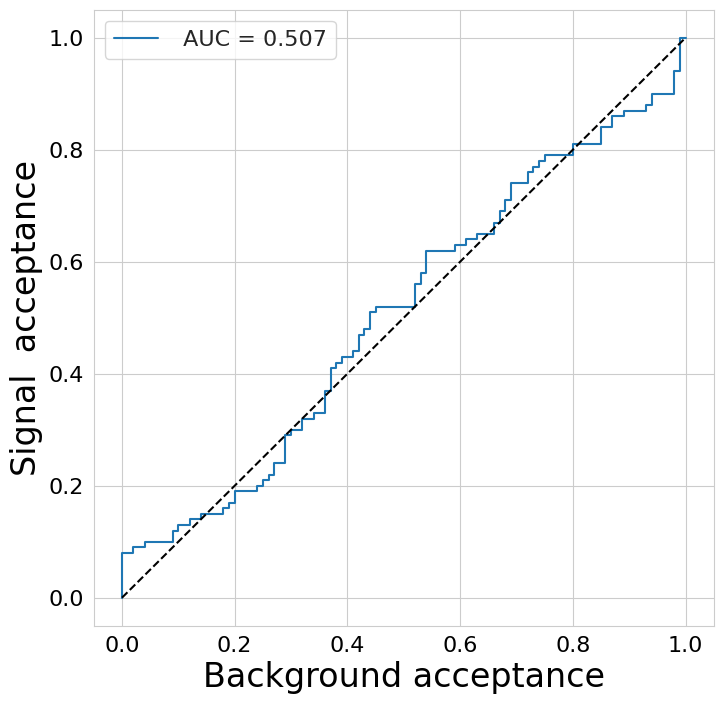

{'': 0.5072000000000001}

In [27]:
plot_roc(df, pred_name='lowest_frac')

## Simple ranking + pooling

### Avg

In [28]:
from tomopt.plotting.appearance import *

def plot_pred(pred):
    with sns.axes_style(style="whitegrid", rc={"patch.edgecolor": "none"}):
        fig, axs = plt.subplots(1, len(pred), figsize=(W_MID, H_MID))

        for i in range(len(pred)):
            sns.heatmap(
                pred[i],
                ax=axs[i],
                cmap="viridis",
                square=True,
                cbar=False,
                vmin=np.nanmin(pred),
                vmax=np.nanmax(pred),
            )
        plt.show()

In [31]:
data[0]

tensor([[[0.6111, 0.2975, 0.2722, 0.4242, 0.6541, 0.6760, 0.8178, 1.0376,
          1.2966, 1.4560],
         [0.6182, 0.2919, 0.2637, 0.3276, 0.4271, 0.6776, 0.7911, 0.9037,
          1.5569, 1.7349],
         [0.7730, 0.5013, 0.3879, 0.1863, 0.2613, 0.4306, 0.6913, 0.9731,
          1.4342, 1.7585],
         [0.5500, 0.6291, 0.5082, 0.1009, 0.1305, 0.1314, 0.1980, 0.2957,
          0.7755, 1.1100],
         [1.3831, 1.1524, 0.8786, 0.6145, 0.2732, 0.2940, 0.3953, 0.2942,
          0.5185, 0.9320],
         [1.2609, 0.8443, 0.3374, 0.5798, 0.5651, 0.2514, 0.1657, 0.1699,
          0.1888, 0.4138],
         [0.7935, 0.9414, 0.3162, 0.5707, 0.1104, 0.1897, 0.1565, 0.2010,
          0.2721, 0.4898],
         [0.7955, 0.6685, 0.5695, 0.2165, 0.1237, 0.1670, 0.2443, 0.7013,
          0.7540, 1.1823],
         [0.6556, 0.5963, 0.5251, 0.3331, 0.2028, 0.4612, 0.5269, 0.8798,
          1.0154, 1.2235],
         [0.7425, 0.6804, 0.7037, 0.3952, 0.9210, 0.7238, 0.8470, 0.9237,
          0.8786,

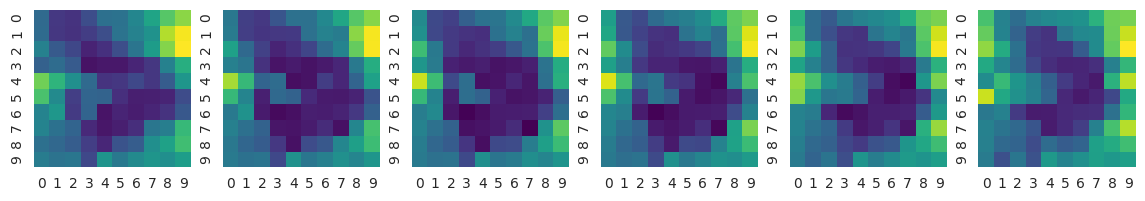

In [37]:
plot_pred(data[0])

In [38]:
data[:,None].shape

torch.Size([200, 1, 6, 10, 10])

In [39]:
F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1).shape

torch.Size([200, 1, 6, 10, 10])

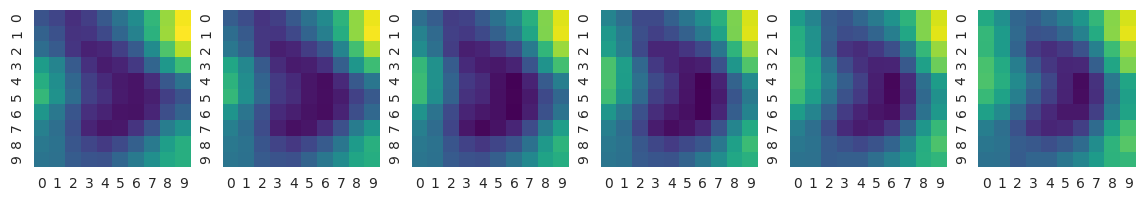

In [40]:
plot_pred(F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[0,0])

In [41]:
avgdata = F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1, count_include_pad=False)[:,0]
df['lowest_frac_avgpool'] = torch.stack([lowest_frac(d) for d in avgdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


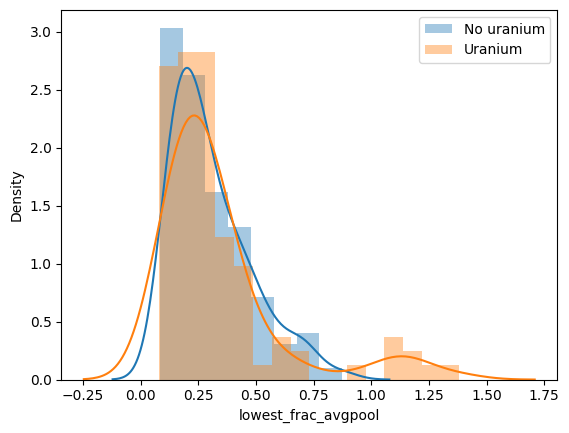

In [42]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_avgpool'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_avgpool'], label='Uranium')
plt.legend()

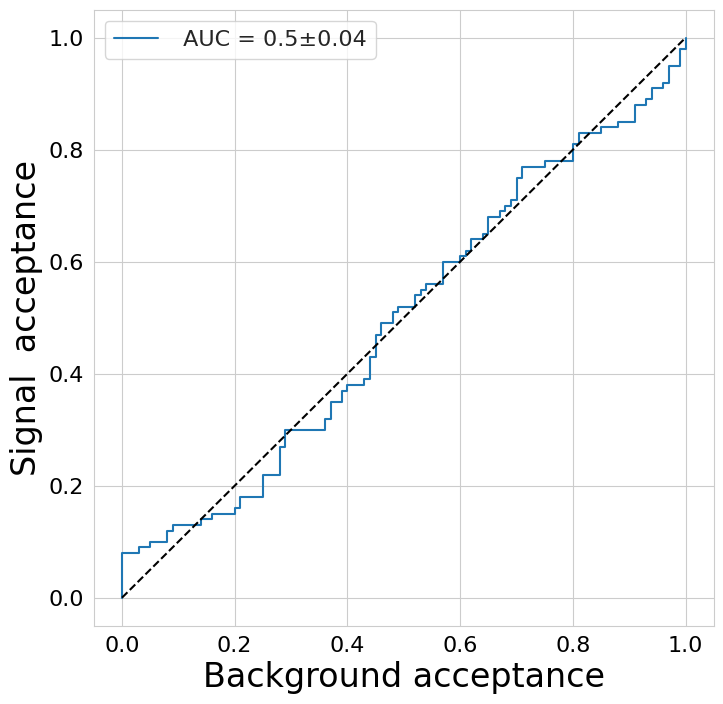

{'': (0.50176261017586, 0.04466616273719565)}

In [43]:
plot_roc(df, pred_name='lowest_frac_avgpool', n_bootstrap=100)

### Max

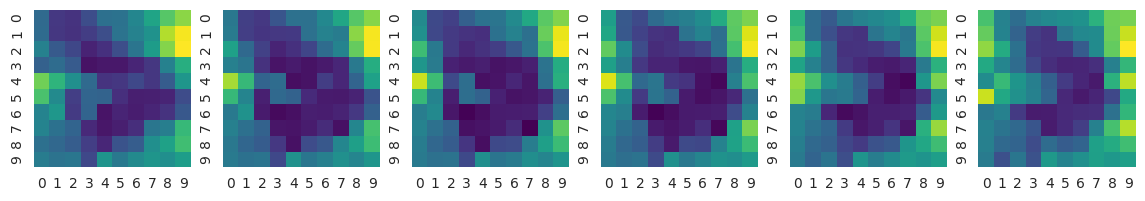

In [44]:
plot_pred(data[0])

In [45]:
data[:,None].shape

torch.Size([200, 1, 6, 10, 10])

In [46]:
F.avg_pool3d(data[:,None], kernel_size=3, stride=1, padding=1).shape

torch.Size([200, 1, 6, 10, 10])

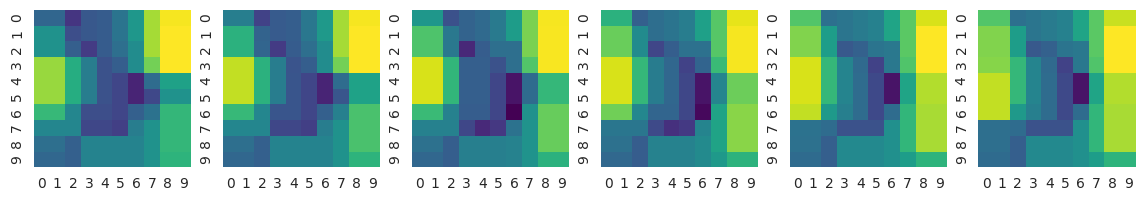

In [47]:
plot_pred(F.max_pool3d(data[:,None], kernel_size=3, stride=1, padding=1)[0,0])

In [48]:
maxdata = F.max_pool3d(data[:,None], kernel_size=3, stride=1, padding=1)[:,0]
df['lowest_frac_maxpool'] = torch.stack([lowest_frac(d) for d in maxdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


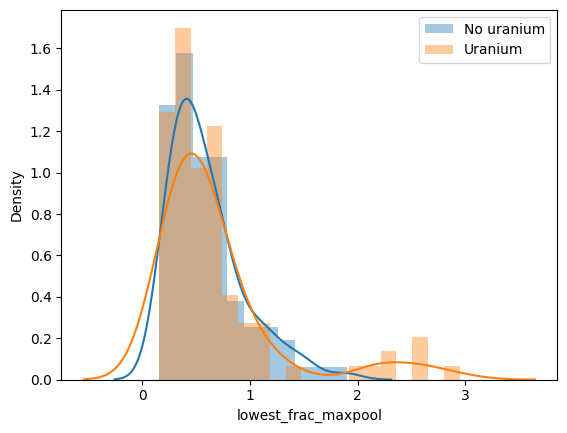

In [49]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_maxpool'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_maxpool'], label='Uranium')
plt.legend()

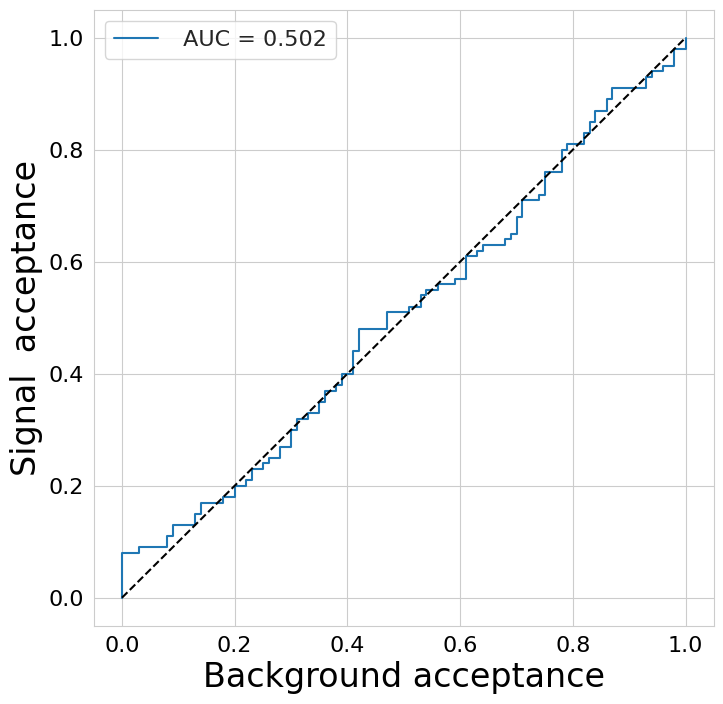

{'': 0.5024000000000001}

In [50]:
plot_roc(df, pred_name='lowest_frac_maxpool')

## Simple ranking + pooling + better diff

In [51]:
def lowest_frac_diff(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    return vox_preds[vox_preds>=cut].mean()-vox_preds[vox_preds<cut].mean()

In [52]:
df['lowest_frac_diff'] = torch.stack([lowest_frac_diff(d) for d in avgdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


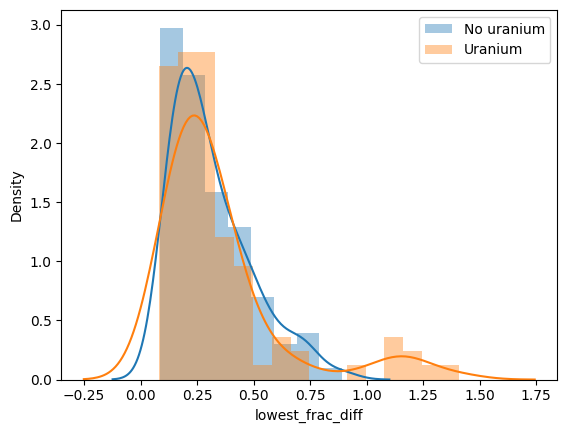

In [53]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_diff'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_diff'], label='Uranium')
plt.legend()

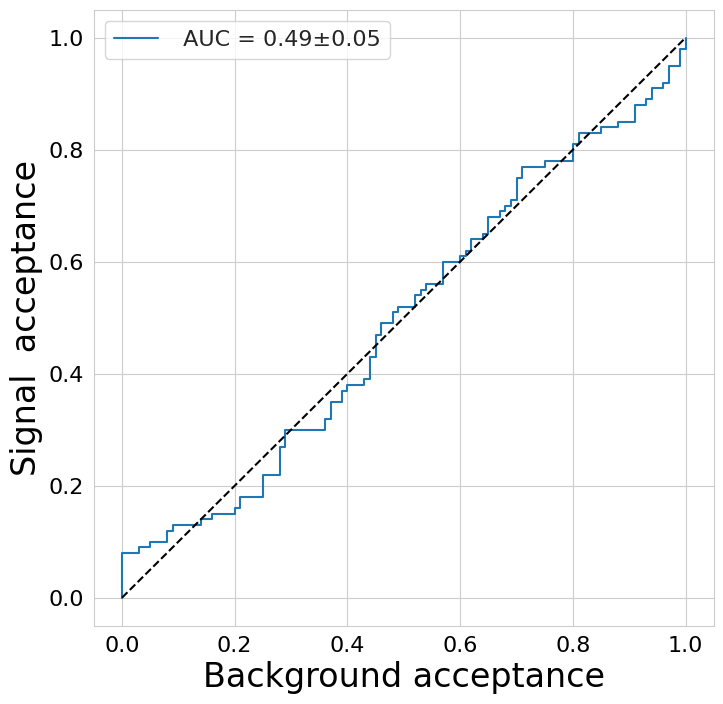

{'': (0.4944640669538054, 0.04517750760598671)}

In [54]:
plot_roc(df, pred_name='lowest_frac_diff', n_bootstrap=100)

## Simple ranking + pooling + better diff + ratio

In [55]:
def lowest_frac_diff_ratio(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    cut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    a = vox_preds[vox_preds>=cut].mean()
    b = vox_preds[vox_preds<cut].mean()
    r = 2*(a-b)/(a+b)
    return F.sigmoid((r-1)*1)

In [56]:
df['lowest_frac_diff_ratio'] = torch.stack([lowest_frac_diff_ratio(d) for d in avgdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


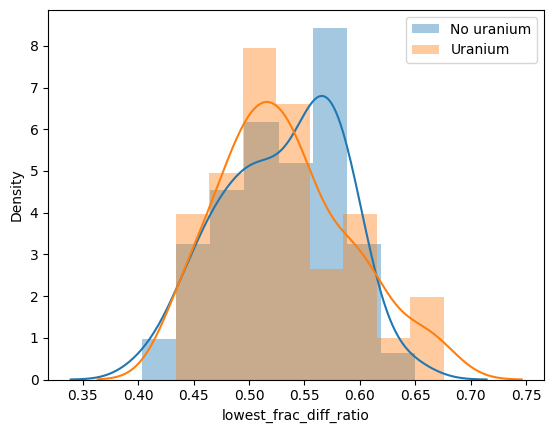

In [57]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_frac_diff_ratio'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_frac_diff_ratio'], label='Uranium')
plt.legend()

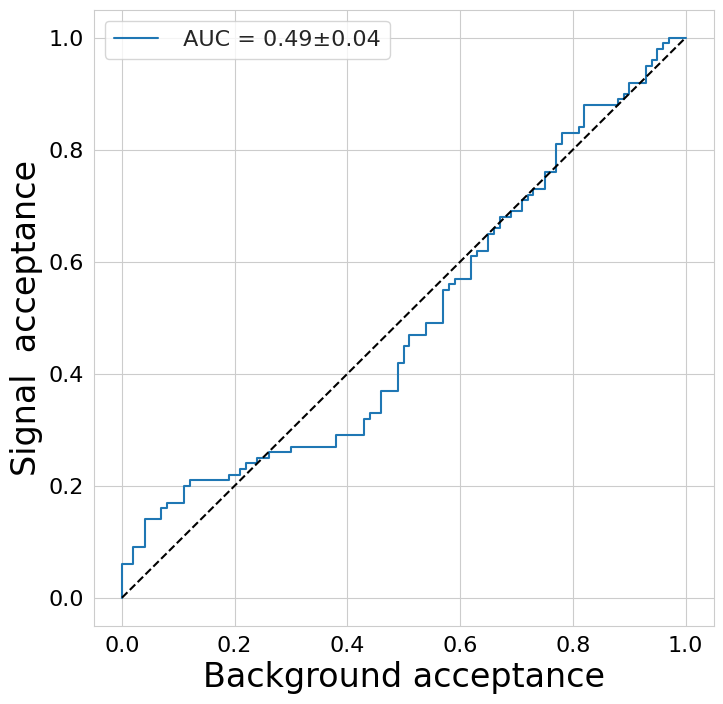

{'': (0.48769982561179714, 0.0424292294793659)}

In [58]:
plot_roc(df, pred_name='lowest_frac_diff_ratio', n_bootstrap=100)

## Max-Min

In [59]:
def max_min(vox_preds:Tensor) -> Tensor:
    return vox_preds.max()-vox_preds.min()

In [60]:
max_min(data[0])

tensor(1.7402)

In [61]:
df['max_min'] = torch.stack([max_min(d) for d in avgdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


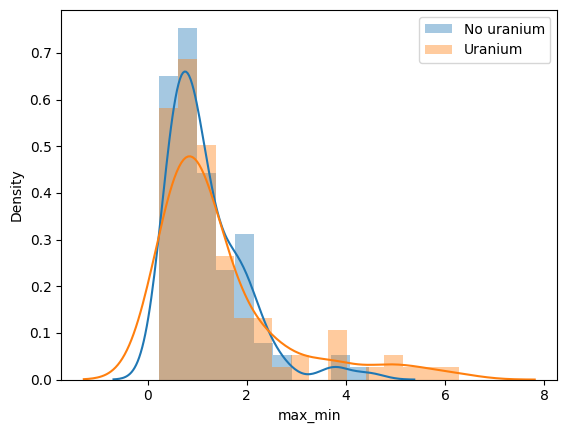

In [62]:
sns.distplot(df.loc[df.gen_target == 0, 'max_min'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'max_min'], label='Uranium')
plt.legend()

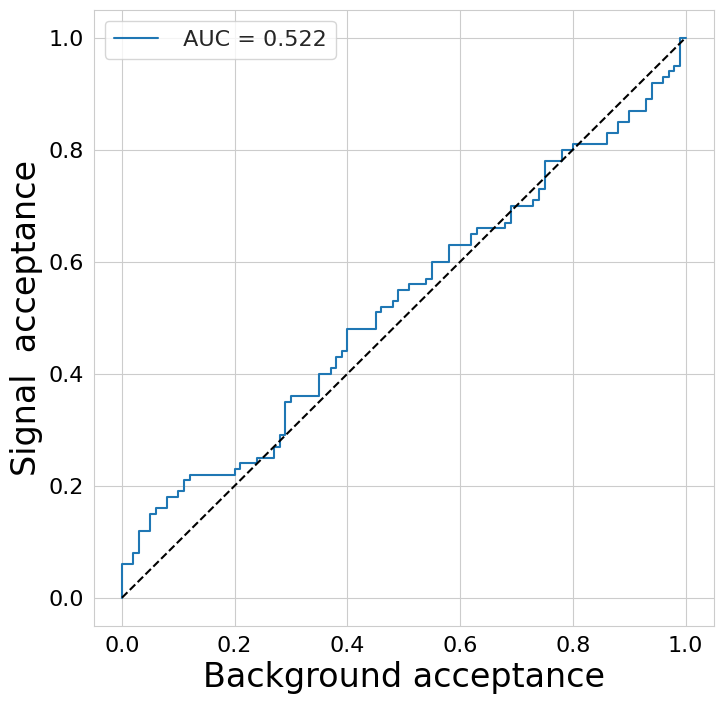

{'': 0.5225}

In [63]:
plot_roc(df, pred_name='max_min')

## Maxfrac-Minfrac

In [64]:
def lowest_highest_frac(vox_preds:Tensor, frac:float = 12/600) -> Tensor:
    lowcut = vox_preds.view(-1).kthvalue(1+round(frac*(vox_preds.numel()-1))).values
    highcut = vox_preds.view(-1).kthvalue(1+round((1-frac)*(vox_preds.numel()-1))).values
    
    return vox_preds[vox_preds>=highcut].mean()-vox_preds[vox_preds<lowcut].mean()

In [65]:
lowest_highest_frac(data[0])

tensor(1.6522)

In [66]:
df['lowest_highest_frac'] = torch.stack([lowest_highest_frac(d) for d in avgdata.unbind()])

/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/zzaher/software/miniconda3/envs/mode/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


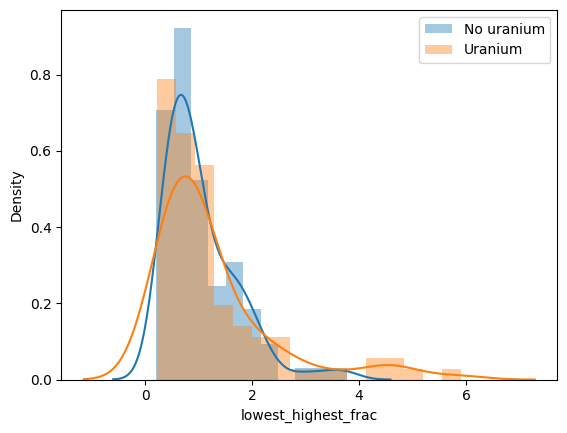

In [67]:
sns.distplot(df.loc[df.gen_target == 0, 'lowest_highest_frac'], label='No uranium')
sns.distplot(df.loc[df.gen_target == 1, 'lowest_highest_frac'], label='Uranium')
plt.legend()

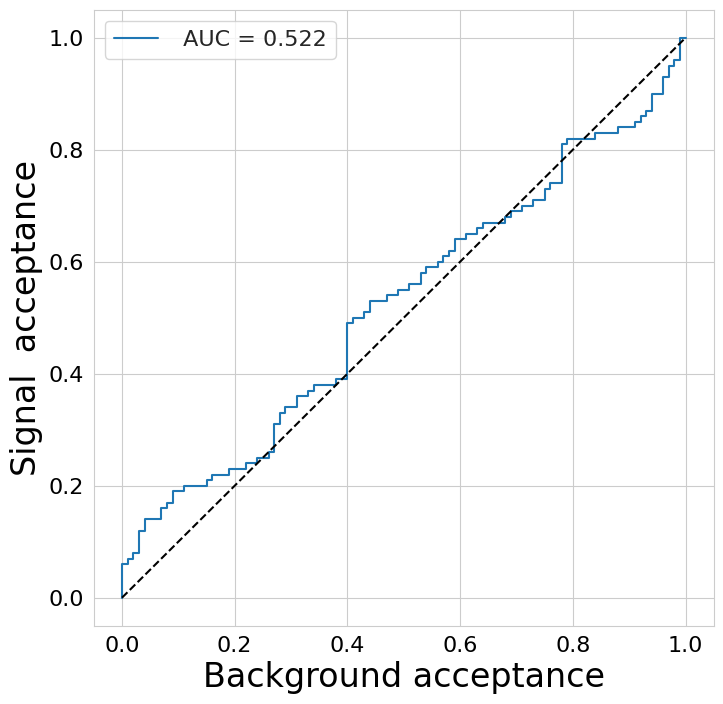

{'': 0.5223}

In [68]:
plot_roc(df, pred_name='lowest_highest_frac')